In [1]:
%run Classifier_class.ipynb

### background info: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

In [2]:
class RandomForest_Classifier(Classifier):
    def run(self, gene_ids):
        super().run(gene_ids)
        
        # Here can go the code to run the SVM classifier itself. For now code it below.
        # Output prediction list and true list

In [3]:
# Initialize a classifier instance
c = RandomForest_Classifier()

In [4]:
preselected_ensgs = pd.read_csv('data/preselectedList', names=['ENSG'])

# function to perform grid search for hyperparameters

In [492]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, make_scorer, f1_score, recall_score, accuracy_score, precision_score, confusion_matrix

def grid_search_wrapper(model, train_values, train_labels, test_values, test_labels, refit_score='f1_score'):
    """
    Fit GridSearchCV classifier and print out scores
    """
    param_options = {
        'n_estimators' : [8, 9, 10, 11, 12, 13],
        'max_depth': [2, 3, 7],
        'min_samples_split': [2, 3],
        'max_features': [None, 'sqrt', 'log2']
    }
    

    score_options = {
        'precision_score': make_scorer(precision_score),
        'recall_score': make_scorer(recall_score),
        'f1_score': make_scorer(f1_score),
        
    }
    
    skf = StratifiedKFold(n_splits=3)
    grid_search = GridSearchCV(model, param_options, scoring=score_options, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(train_values, train_labels)

    # make the predictions
    predicted_test_labels = grid_search.predict(test_values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(test_labels)
    print(predicted_test_labels)
    print(pd.DataFrame(confusion_matrix(test_labels, predicted_test_labels),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

# Perform grid search to optimize hyper parameters

In [493]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# Random seed for reproducibility
SEED = 12

c.run(None)
#c.run(list(preselected_ensgs.ENSG))

# most important 72 features when using 12 estimators and sqrt max features
"""
max_features = ['ENSG00000114346', 'ENSG00000160255', 'ENSG00000085832', 'ENSG00000003756', 'ENSG00000174371', 
       'ENSG00000112130', 'ENSG00000120708', 'ENSG00000106305', 'ENSG00000160094', 'ENSG00000173898',
       'ENSG00000197019', 'ENSG00000089157', 'ENSG00000241697', 'ENSG00000039068', 'ENSG00000087253',
       'ENSG00000184363', 'ENSG00000168646', 'ENSG00000100197', 'ENSG00000139687', 'ENSG00000239672', 
       'ENSG00000101935', 'ENSG00000104205', 'ENSG00000124920', 'ENSG00000150403', 'ENSG00000144354', 
       'ENSG00000133884', 'ENSG00000148248', 'ENSG00000084207', 'ENSG00000166482', 'ENSG00000129625', 
       'ENSG00000133789', 'ENSG00000158717', 'ENSG00000177508', 'ENSG00000187790', 'ENSG00000185432', 
       'ENSG00000076003', 'ENSG00000163156', 'ENSG00000164161', 'ENSG00000112977', 'ENSG00000121879', 
       'ENSG00000134333', 'ENSG00000215252', 'ENSG00000145715', 'ENSG00000178999', 'ENSG00000170502', 
       'ENSG00000136738', 'ENSG00000145335', 'ENSG00000099622', 'ENSG00000198815', 'ENSG00000151693', 
       'ENSG00000100298', 'ENSG00000107262', 'ENSG00000148935', 'ENSG00000047849', 'ENSG00000168874', 
       'ENSG00000166483', 'ENSG00000169136', 'ENSG00000146648', 'ENSG00000150401', 'ENSG00000154229',
       'ENSG00000158270', 'ENSG00000171552', 'ENSG00000102753', 'ENSG00000166579', 'ENSG00000094804',
       'ENSG00000127252', 'ENSG00000113810', 'ENSG00000066697', 'ENSG00000125414', 'ENSG00000112715',
       'ENSG00000184182']
"""
#c.run(max_features)


def run_override(data, parameters=None):
    # Code the SVM classification process here for now, so that you don't have to reinstantiate the classifier 
    # (block above) every time you make a change. Parameters are optional, no need to include them until fine-tuning
    # probably.
    
    # Extract the labels
    labels = np.array(c.subsetted_tpm.index.get_level_values(1))

    # Set aside test data
    train, test, train_labels, test_labels = train_test_split(data, 
                                                              labels, 
                                                              stratify = labels,
                                                              test_size=0.3,
                                                              random_state = SEED)

    print('\t{} examles in training set'.format(len(train)))
    print('\t{} examples in test set'.format(len(test)))
    
    print('\t{}: fraction of positives in training set'.format(
        sum(train.index.get_level_values(1))/len(train.index.get_level_values(1))))
    print('\t{}: fraction of positives in test set'.format(
        sum(test.index.get_level_values(1))/len(test.index.get_level_values(1))))

    # Make a model
    model = RandomForestClassifier(
        #n_estimators=12, 
        random_state=SEED, 
        #max_features = 'sqrt',
    )

    return grid_search_wrapper(model, train, train_labels, test, test_labels)
    
grid_search_results = run_override(c.subsetted_tpm)


Running classifier with 60675 genes...
	67 examles in training set
	29 examples in test set
	0.29850746268656714: fraction of positives in training set
	0.27586206896551724: fraction of positives in test set
Best params for f1_score
{'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 8}

Confusion matrix of Random Forest optimized for f1_score on the test data:
[0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
     pred_neg  pred_pos
neg        20         1
pos         8         0


/Users/erickofman/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [494]:
# The recall is the ratio tp / (tp + fn)
# The precision is ratio tp / (tp + fp)

In [495]:

results = pd.DataFrame(grid_search_results.cv_results_)
results = results.sort_values(by='mean_test_recall_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_f1_score', 'param_min_samples_split', 'param_max_depth', 'param_max_features', 'param_n_estimators']].round(3).head()


,mean_test_precision_score,mean_test_recall_score,mean_test_f1_score,param_min_samples_split,param_max_depth,param_max_features,param_n_estimators
54,0.750,0.304,0.399,3,3,sqrt,8
48,0.750,0.304,0.399,2,3,sqrt,8
91,0.552,0.301,0.374,3,7,sqrt,9
55,0.552,0.301,0.374,3,3,sqrt,9
49,0.552,0.301,0.374,2,3,sqrt,9


In [22]:
np.log2(c.subsetted_tpm+1).head()

,ENSG,ENSG00000002330,ENSG00000003756,ENSG00000003989,ENSG00000006125,ENSG00000006459,ENSG00000007237,ENSG00000008018,ENSG00000008394,ENSG00000009950,ENSG00000010810,...,ENSG00000262117,ENSG00000265190,ENSG00000265972,ENSG00000267534,ENSG00000267696,ENSG00000268089,ENSG00000272143,ENSG00000277586,ENSG00000280236,ENSG00000280997
,HGNC,BAD,RBM5,SLC7A2,AP2B1,KDM7A,GAS7,PSMB1,MGST1,MLXIPL,FYN,...,BCAR4,ANXA8,TXNIP,S1PR2,ERVK-28,GABRQ,FGF14-AS2,NEFL,OR12D2,CCAT2
sample,recurrence,,,,,,,,,,,,,,,,,,,,,
C1,1,3.756752,2.845247,3.988709,4.934918,3.868220,4.164666,3.927451,4.822705,1.687117,3.947141,...,5.623451,1.658736,5.757048,3.693472,0.000000,2.631338,4.947670,3.738428,0.0,3.722804
C2,1,3.313334,3.676136,3.654270,4.096077,3.624746,3.534006,3.861730,4.679757,2.060551,4.433310,...,3.643730,2.029222,4.463546,0.000000,0.000000,3.445815,0.000000,2.178715,0.0,4.762785
C3,1,4.668056,3.708199,4.679523,3.345332,4.530936,3.211052,5.464152,4.763671,0.000000,3.615581,...,3.519851,1.928355,5.962844,3.131538,5.577087,4.067823,0.000000,4.341418,0.0,6.702860
C4,1,2.829930,3.915767,4.074074,4.687089,4.784596,3.212037,3.357871,5.172690,3.273521,4.043587,...,4.063305,0.000000,4.586909,4.603412,0.000000,3.478417,3.421891,4.342467,0.0,3.690850
C5,1,0.000000,3.395858,4.515016,4.110349,5.183784,3.256444,0.000000,4.598762,1.833479,4.604164,...,6.046008,2.580875,4.172183,2.152677,0.000000,3.700595,3.643259,5.628791,0.0,0.000000


In [155]:
#### from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# Random seed for reproducibility
SEED = 11


#c.run(None)

def run_override_using_optimal(data, gene_list_name, seed=SEED, parameters=None):
    # Code the SVM classification process here for now, so that you don't have to reinstantiate the classifier 
    # (block above) every time you make a change. Parameters are optional, no need to include them until fine-tuning
    # probably.
    
    # Extract the labels
    data = np.log2(data+1)
    labels = np.array(data.index.get_level_values(1))

    print('Num genes: {}'.format(len(data.columns)))
    
    # Set aside test data
    train, test, train_labels, test_labels = train_test_split(data, 
                                                              labels, 
                                                              stratify = labels,
                                                              test_size=0.3,
                                                              random_state = SEED)

    #print('\t{} examples in training set'.format(len(train)))
    #print('\t{} examples in test set'.format(len(test)))
    
    #print('\t{}: fraction of positives in training set'.format(
    #    sum(train.index.get_level_values(1))/len(train.index.get_level_values(1))))
    #print('\t{}: fraction of positives in test set'.format(
    #    sum(test.index.get_level_values(1))/len(test.index.get_level_values(1))))

    # Make a model
    model = RandomForestClassifier(
        n_estimators=8,
        random_state=seed,
        max_features = 'sqrt',
        max_depth = 3,
        min_samples_split = 3
    )

    
    # Train model
    model.fit(train, train_labels)

    # Original guesses using default 0.5 threshold
    guesses = model.predict(test)
    
    # Probabilities per class
    probs = model.predict_proba(test)[:, 1]
    
    # Adjusted guess using a threshold optimized for reducing false negatives
    adjusted_guesses = guesses#[1 if p > 0.35 else 0 for p in probs]
    
    roc_value = roc_auc_score(test_labels, probs)
    #print('roc_value:', roc_value)
    
    #print(pd.DataFrame(confusion_matrix(test_labels, guesses),
    #             columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    
    #print(pd.DataFrame(confusion_matrix(test_labels, adjusted_guesses),
    #                   columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
        
    fpr, tpr, thresholds = roc_curve(test_labels, probs, pos_label=1)
    print('{} AUC: {}'.format(gene_list_name, roc_value))
    sys.stdout.write('fpr: [')
    for f in fpr:
        sys.stdout.write('{}, '.format(f))
    sys.stdout.write(']\n')
    sys.stdout.write('tpr: [')
    for t in tpr:
        sys.stdout.write('{}, '.format(t))
    sys.stdout.write(']\n')
    
    #print('Thresholds: ', thresholds)
    #plt.figure()
    #plt.plot(fpr, tpr)
    #plt.xlabel('False Positive Rate')
    #plt.ylabel('True Positive Rate')
    #plt.title('{}: ROC curve (AUC = {})'.format(gene_list_name, roc_value))

    feature_importance = pd.DataFrame({
        'feature': list(train.columns),
        'importance': model.feature_importances_}).\
    sort_values('importance', ascending = False)
    return roc_value, feature_importance
    
    #most_important_ensgs = [i[0] for i in  list(feature_importance[1:72].feature)]
    #print(most_important_ensgs)


preselected_ensgs = pd.read_csv('data/preselectedList', names=['ENSG'])
optimized_78 = ['ENSG00000151725',
 'ENSG00000112130',
 'ENSG00000007237',
 'ENSG00000139734',
 'ENSG00000106605',
 'ENSG00000118816',
 'ENSG00000115461',
 'ENSG00000129925',
 'ENSG00000119231',
 'ENSG00000150403',
 'ENSG00000203747',
 'ENSG00000151465',
 'ENSG00000162783',
 'ENSG00000180543',
 'ENSG00000213281',
 'ENSG00000155090',
 'ENSG00000162702',
 'ENSG00000164161',
 'ENSG00000214541',
 'ENSG00000186298',
 'ENSG00000159166',
 'ENSG00000184990',
 'ENSG00000168496',
 'ENSG00000129515',
 'ENSG00000183864',
 'ENSG00000112414',
 'ENSG00000164099',
 'ENSG00000113532',
 'ENSG00000047849',
 'ENSG00000135766',
 'ENSG00000154978',
 'ENSG00000066468',
 'ENSG00000100146',
 'ENSG00000170502',
 'ENSG00000136854',
 'ENSG00000067221',
 'ENSG00000198276',
 'ENSG00000117616',
 'ENSG00000100243',
 'ENSG00000119844',
 'ENSG00000030110',
 'ENSG00000154556',
 'ENSG00000139182',
 'ENSG00000162894',
 'ENSG00000163956',
 'ENSG00000148935',
 'ENSG00000002330',
 'ENSG00000196363',
 'ENSG00000183853',
 'ENSG00000196411',
 'ENSG00000280236',
 'ENSG00000249310',
 'ENSG00000078114',
 'ENSG00000131171',
 'ENSG00000164039',
 'ENSG00000110848',
 'ENSG00000277586',
 'ENSG00000164414',
 'ENSG00000167447',
 'ENSG00000161981',
 'ENSG00000125730',
 'ENSG00000184182',
 'ENSG00000141510',
 'ENSG00000185924',
 'ENSG00000115648',
 'ENSG00000166927',
 'ENSG00000173451',
 'ENSG00000095794',
 'ENSG00000058262',
 'ENSG00000122591',
 'ENSG00000170145',
 'ENSG00000265972',
 'ENSG00000105327',
 'ENSG00000102753',
 'ENSG00000101935',
 'ENSG00000154359',
 'ENSG00000120709',
 'ENSG00000178209']

CTD_cancer_genes = pd.read_csv('data/CTD_cancer_genes', names=['ENSG'])
Cancer_census_genes = pd.read_csv('data/Cancer_census_genes', names=['ENSG'])
GSEA_KRAS_BREAST_UP_V1_UP = pd.read_csv('data/GSEA_KRAS_BREAST_UP_V1_UP', names=['ENSG'])
GSEA_VANTVEER_BREAST_CANCER_POOR_PROGNOSIS = pd.read_csv('data/GSEA_VANTVEER_BREAST_CANCER_POOR_PROGNOSIS', names=['ENSG'])
top_de_ensgs = ['ENSG00000243260', 'ENSG00000272795', 'ENSG00000266258', 'ENSG00000227303', 'ENSG00000167468', 'ENSG00000261058', 'ENSG00000212694', 'ENSG00000253171', 'ENSG00000181819', 'ENSG00000260846', 'ENSG00000226318', 'ENSG00000226694', 'ENSG00000251497', 'ENSG00000268458', 'ENSG00000243601', 'ENSG00000239801', 'ENSG00000048545', 'ENSG00000242078', 'ENSG00000255349', 'ENSG00000214360', 'ENSG00000271114', 'ENSG00000258051', 'ENSG00000178096', 'ENSG00000227824', 'ENSG00000222743', 'ENSG00000272455', 'ENSG00000236005', 'ENSG00000279342', 'ENSG00000234427', 'ENSG00000197790', 'ENSG00000278967', 'ENSG00000231548', 'ENSG00000224945', 'ENSG00000253042', 'ENSG00000185701', 'ENSG00000262259', 'ENSG00000201351', 'ENSG00000248799', 'ENSG00000282834', 'ENSG00000242154', 'ENSG00000123810', 'ENSG00000236398', 'ENSG00000272506', 'ENSG00000172201', 'ENSG00000267109', 'ENSG00000099860', 'ENSG00000233286', 'ENSG00000253341', 'ENSG00000125656', 'ENSG00000257935', 'ENSG00000227197', 'ENSG00000155918', 'ENSG00000141504', 'ENSG00000238207', 'ENSG00000282024', 'ENSG00000271257', 'ENSG00000204950', 'ENSG00000267312', 'ENSG00000250657', 'ENSG00000141985', 'ENSG00000259657', 'ENSG00000269931', 'ENSG00000231620', 'ENSG00000276531', 'ENSG00000224333', 'ENSG00000277975', 'ENSG00000227495', 'ENSG00000236565', 'ENSG00000228610', 'ENSG00000255745', 'ENSG00000124449', 'ENSG00000265934', 'ENSG00000254667', 'ENSG00000176410', 'ENSG00000235743', 'ENSG00000242190', 'ENSG00000253899', 'ENSG00000233343', 'ENSG00000203363', 'ENSG00000123594', 'ENSG00000259699', 'ENSG00000270139', 'ENSG00000235943', 'ENSG00000268105', 'ENSG00000213791', 'ENSG00000249479', 'ENSG00000243953', 'ENSG00000253986', 'ENSG00000258120', 'ENSG00000226705', 'ENSG00000243871', 'ENSG00000255032', 'ENSG00000176401', 'ENSG00000240459', 'ENSG00000101470', 'ENSG00000268093', 'ENSG00000261161', 'ENSG00000225251', 'ENSG00000235098', 'ENSG00000105146']

from collections import defaultdict
gene_list_name_to_auc_values = defaultdict(lambda:[])
gene_list_name_to_average_auc = defaultdict()

#for gene_list, gene_list_name in zip([optimized_78, 
#                                      preselected_ensgs, 
#                                       Cancer_census_genes,
#                                      GSEA_KRAS_BREAST_UP_V1_UP, 
#                                      GSEA_VANTVEER_BREAST_CANCER_POOR_PROGNOSIS,
#                                      top_de_ensgs
#                                 ], ['Optimized_78', 'Top_750',  'Cancer_census', 'KRAS', 'POOR_PROGNOSIS', '100_Top_DE']):
for gene_list, gene_list_name in zip([top_de_ensgs], ['100_Top_DE']):
    roc_values = []
    feature_importances = []
    try:
        c.run(list(gene_list.ENSG))
    except:
        c.run(gene_list)
    for seed in range(1, 20):
        roc, feature_importance = run_override_using_optimal(c.subsetted_tpm, gene_list_name, seed=seed)
        feature_importances.append(feature_importance)
        roc_values.append(roc)
    
    gene_list_name_to_auc_values[gene_list_name] = roc_values
    #plt.figure()
    #plt.hist(roc_values)
    gene_list_name_to_average_auc[gene_list_name] = sum(roc_values)/len(roc_values)
    #plt.title(gene_list_name)


Running classifier with 100 genes...
Num genes: 100
100_Top_DE AUC: 0.8214285714285714
fpr: [0.0, 0.0, 0.0, 0.047619047619047616, 0.047619047619047616, 0.14285714285714285, 0.14285714285714285, 0.3333333333333333, 0.3333333333333333, 0.8095238095238095, 0.8095238095238095, 0.9523809523809523, 1.0, ]
tpr: [0.0, 0.125, 0.25, 0.25, 0.625, 0.625, 0.75, 0.75, 0.875, 0.875, 1.0, 1.0, 1.0, ]
Num genes: 100
100_Top_DE AUC: 0.8720238095238095
fpr: [0.0, 0.0, 0.0, 0.14285714285714285, 0.14285714285714285, 0.19047619047619047, 0.2857142857142857, 0.5238095238095238, 0.6190476190476191, 0.8095238095238095, 0.9523809523809523, 1.0, ]
tpr: [0.0, 0.125, 0.75, 0.75, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 1.0, 1.0, ]
Num genes: 100
100_Top_DE AUC: 0.8482142857142856
fpr: [0.0, 0.0, 0.0, 0.047619047619047616, 0.09523809523809523, 0.09523809523809523, 0.14285714285714285, 0.23809523809523808, 0.3333333333333333, 0.6190476190476191, 0.8095238095238095, 1.0, ]
tpr: [0.0, 0.125, 0.5, 0.625, 0.625, 0.75, 

In [156]:
top_features_counts = defaultdict(lambda:0)
for f in feature_importances:
    top_genes = ([t[1] for t in (list(f.head(25).feature))])
    for l in top_genes:
        top_features_counts[l] += 1

top_features_counts

for k in {k:v for k, v in sorted(top_features_counts.items(), key=lambda item: item[1], reverse=True)}.keys():
    print(k)

AC099336.3
AC093663.1
LINC01089
KCTD9P2
AC084864.1
IRGC
ENSG00000254667
AC011990.1
RPS3AP38
LRRC10B
ID4
AC126283.1
AC122136.1
LINC01909
PIGHP1
SH3GL1
BOLA1
EID2B
FRG2HP
AP001172.2
GUCA1A
PDCL2P1
AL353150.1
MTND3P10
AC073359.1
AC074029.2
AC037450.1
SAT2
AC104561.3
AL590392.1
HMGB1P8
AURKC
AC067904.2
TAS2R39
AP000787.3
RNU6-1190P
AP000866.6
OR52M1
AC023796.1
AC022118.1
OR5M5P
RAET1L
LHX5-AS1
AC008814.1
RN7SL487P
RPL12P24
AC099508.2
DNAJC30
ANKRD65
EFCAB9
AL355074.1
AL138847.2
CLPP
AC124856.1
AC022154.1
OR55B1P
HNRNPA3P5
AC011468.3
AL441943.1
GPR160P1
ATP6V1G1P4
AL139231.1
CSTP2
RN7SL558P
AL078623.1
AC015911.4
AC017015.2
GADD45B
MTND4LP24
AC115837.1
AL391244.2
AC239727.1
GAPDHP20
GPX4
KIF1C-AS1
AC104212.2
AL009031.1
PITPNM2-AS1
ATXN3L
AL357078.2
DENND6A-AS1
KRT128P
AC004884.2
TNNC2
AP000855.1
AC009312.1
TSPAN18-AS1
ARL2BPP1
RPL5P25
AL022724.2
SDCBPP1
AC009154.1


Text(0.5, 1.0, 'Random Forest AUC for 100 Cross-Validations of Various Gene Sets')

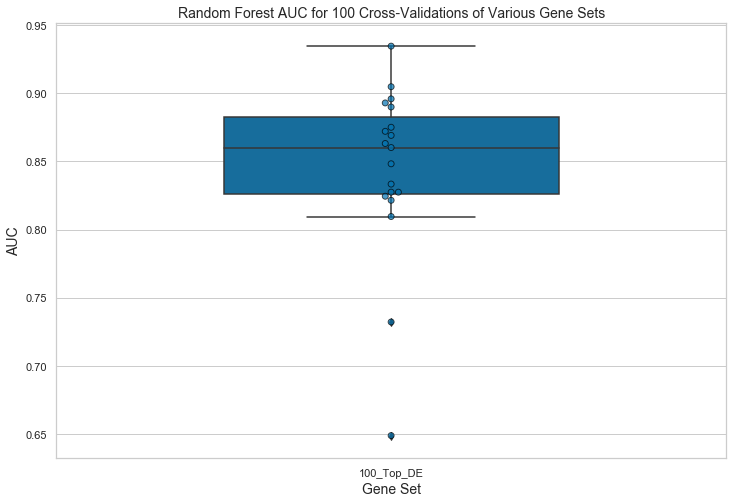

In [157]:
import seaborn as sns

gene_set_comparison = pd.DataFrame(gene_list_name_to_auc_values)

plt.figure(figsize=(12,8))
sns.set(context='notebook', style='whitegrid')
sns.boxplot(data=gene_set_comparison, width=0.5, palette="colorblind", orient="v")
auc = sns.swarmplot(data=gene_set_comparison, size=6, edgecolor="black", linewidth=.9, palette="colorblind", marker='o', alpha=0.7)
auc.set_xlabel("Gene Set", fontsize=14)
auc.set_ylabel("AUC", fontsize=14)
auc.axes.set_title("Random Forest AUC for 100 Cross-Validations of Various Gene Sets", fontsize=14)


In [154]:
for k, v in gene_list_name_to_auc_values.items():
    print(sum(v)/len(v))

0.5766594516594516
0.5117243867243865
0.4832251082251082
0.47646103896103886
0.5431096681096679
0.8430435305435301
